## SwinUNETR for Wrist Bone Segmentation

In this section, we explore the SwinUNETR architecture for the segmentation of wrist bones. SwinUNETR combines the strengths of Swin Transformers with the U-Net architecture, aiming to capture both global context and local details effectively. This hybrid approach leverages the Swin Transformer's ability to model long-range dependencies and hierarchical features, while the U-Net structure provides precise localization of anatomical structures. By employing the SwinUNETR model, we focus on its potential to enhance segmentation accuracy, especially in handling varying scales of anatomical features and complex spatial relationships in wrist bones. Despite its innovative approach, we analyze the model's performance to identify areas for improvement in capturing fine anatomical details and ensuring consistent segmentation results.



### Importing Necessary Libraries

In [1]:
import os
from glob import glob
from monai.transforms import (
    Compose, LoadImaged, AddChanneld, ScaleIntensityRanged, RandFlipd,
    RandAffined, RandRotated, RandZoomd, NormalizeIntensityd, ToTensord, EnsureTyped, EnsureType,EnsureChannelFirstd,SpatialPadd,
    RandCropByPosNegLabeld
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism,first
from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import AsDiscrete, Activations
import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import MapTransform
from monai.metrics import SurfaceDistanceMetric
import nibabel as nib
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors

### Data Loaders and Data Transformations

In [43]:
## CREATING PATHS TO UPLOAD OUR DATA
data_dir = '/workspace/data'

train_images = sorted(glob(os.path.join(data_dir,'imagesTr','*nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir,'labelsTr','*nii.gz')))

val_images = sorted(glob(os.path.join(data_dir,'imagesTs','*nii.gz')))
val_labels = sorted(glob(os.path.join(data_dir,'labelsTs','*nii.gz')))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in  zip(train_images,train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in  zip(val_images,val_labels)]

In [44]:
# Defining original transform
orig_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    ToTensord(keys=['image', 'label'])
])

train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=['image'],  a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    # RandFlipd(keys=['image', 'label'], spatial_axis=[0], prob=0.5),
    RandAffined(keys=['image', 'label'], prob=0.5, rotate_range=(0, 0, np.pi/12), scale_range=(0.1, 0.1, 0.1),
                mode=("nearest", "nearest")),  # Apply nearest neighbors interpolation for both images and labels
    EnsureTyped(keys=['image', 'label']),  # Ensure the data is of the correct type
    ToTensord(keys=['image', 'label'])
])

# Defining validation transforms
val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=['image'], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    EnsureTyped(keys=['image', 'label']),  
    ToTensord(keys=['image', 'label'])
])

In [45]:
test_patient = first(train_loader)
orig_patient = first(orig_loader)

In [46]:
print(torch.min(test_patient['image']))
print(torch.max(test_patient['image']))

tensor(0.)
tensor(1.)


### Comparing Original Image with Preprocessed Image and Labels
In this section, we compare the original images with their preprocessed counterparts and corresponding labels. This comparison highlights the impact of preprocessing on image quality and segmentation accuracy. Preprocessing steps such as normalization, augmentation, and transformation enhance the model's ability to accurately segment the wrist bones by improving the contrast and highlighting relevant features. This analysis is crucial for understanding how preprocessing contributes to the overall performance of the segmentation model.

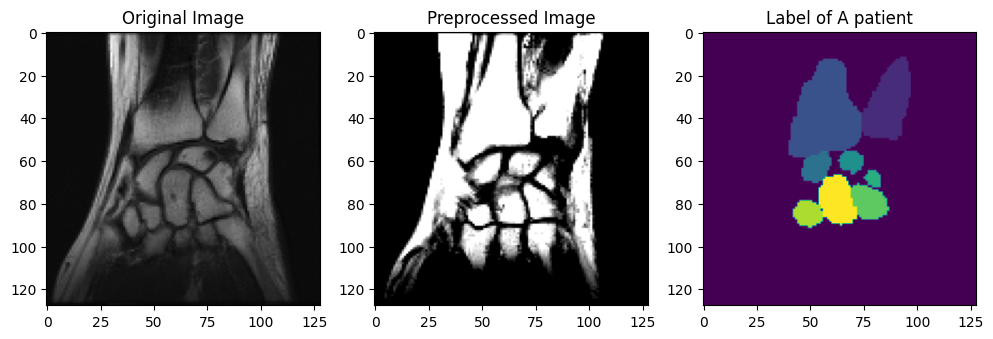

In [51]:
plt.figure('test',(12,6))


plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(orig_patient['image'][0,0,:,:,18], cmap = "gray")   #[b,c,w,h,s]

plt.subplot(1,3,2)
plt.title('Preprocessed Image')
plt.imshow(test_patient['image'][0,0,:,:,18], cmap = "gray")   #[b,c,w,h,s]

plt.subplot(1,3,3)
plt.title('Label of A patient')
plt.imshow(test_patient['label'][0,0,:,:,18])   #[b,c,w,h,s]


In [52]:
sample_label = test_patient['label'][0, 0, :, :, 21].cpu().numpy()
unique_values = np.unique(sample_label)
print(f"Unique label values: {unique_values}")

Unique label values: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


### Training the SwinUNETR Model

In [12]:
import torch
from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss
from monai.transforms import Compose, Activations, AsDiscrete
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the model
model = SwinUNETR(
    img_size=(128, 128, 64),  # Adjusted size to be divisible by 32 in all dimensions
    in_channels=1,
    out_channels=11,  # 10 bones + background
    feature_size=48,  # Reduced feature size
    depths=(2, 2,2,2),  # Example values, adjust as needed
    num_heads=(3, 6,12,24),  # Reduced number of heads
    norm_name="instance",
    use_checkpoint=True,
).to(device)

# Defining the loss function
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

# Defining the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)  # Initial LR 0.001

# Defining a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Defining metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=11)])
post_label = Compose([AsDiscrete(to_onehot=11)])

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Training parameters
max_epochs = 300
val_interval = 2  # Evaluate every 2 epochs
accumulation_steps = 4  # Gradient accumulation
epoch_loss_values = []
metric_values = []
best_metric = -1
best_metric_epoch = -1
best_class_metrics = [0] * 11  # For 11 classes

# Training loop
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    optimizer.zero_grad()

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels) / accumulation_steps
        
        scaler.scale(loss).backward()
        
        if (step % accumulation_steps == 0) or (step == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        epoch_loss += loss.item() * accumulation_steps
        print(f"{step}/{len(train_loader)} train_loss: {loss.item():.4f}")
    
    epoch_loss /= step  # Calculate the average loss over all batches
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Validation loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
            for val_data in val_loader:
                val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_images, (128, 128, 64), 4, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
            
            metric = dice_metric.aggregate().item()
            metric_batch = dice_metric_batch.aggregate()
            dice_metric.reset()
            dice_metric_batch.reset()
            
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_model_swinunetr.pth")
                print("saved new best metric model")
                for i in range(len(metric_batch)):
                    best_class_metrics[i] = metric_batch[i].item()
            
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}")
            for i, dice in enumerate(metric_batch):
                print(f"Class {i} dice: {dice.item():.4f}")
            print(f"best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

# Loading the best model
model.load_state_dict(torch.load("best_model_swinunetr.pth"))
model.eval()

# Evaluating and printing the dice coefficient for every label achieved through the best model
with torch.no_grad():
    dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        val_outputs = sliding_window_inference(val_images, (128, 128, 64), 4, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        dice_metric_batch(y_pred=val_outputs, y=val_labels)
    
    metric_batch = dice_metric_batch.aggregate()
    dice_metric_batch.reset()

    print("Final per-class Dice metrics:")
    for i, dice in enumerate(metric_batch):
        print(f"Class {i} dice: {dice.item():.4f}")


----------
epoch 1/300


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


1/20 train_loss: 0.2429
2/20 train_loss: 0.2426
3/20 train_loss: 0.2434
4/20 train_loss: 0.2424
5/20 train_loss: 0.2394
6/20 train_loss: 0.2404
7/20 train_loss: 0.2399
8/20 train_loss: 0.2405
9/20 train_loss: 0.2380
10/20 train_loss: 0.2362
11/20 train_loss: 0.2363
12/20 train_loss: 0.2383
13/20 train_loss: 0.2356
14/20 train_loss: 0.2357
15/20 train_loss: 0.2362
16/20 train_loss: 0.2349
17/20 train_loss: 0.2347
18/20 train_loss: 0.2341
19/20 train_loss: 0.2359
20/20 train_loss: 0.2334
epoch 1 average loss: 0.9522
----------
epoch 2/300
1/20 train_loss: 0.2322
2/20 train_loss: 0.2317
3/20 train_loss: 0.2322
4/20 train_loss: 0.2309
5/20 train_loss: 0.2306
6/20 train_loss: 0.2314
7/20 train_loss: 0.2316
8/20 train_loss: 0.2311
9/20 train_loss: 0.2329
10/20 train_loss: 0.2277
11/20 train_loss: 0.2270
12/20 train_loss: 0.2338
13/20 train_loss: 0.2277
14/20 train_loss: 0.2289
15/20 train_loss: 0.2281
16/20 train_loss: 0.2262
17/20 train_loss: 0.2258
18/20 train_loss: 0.2261
19/20 train_loss

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


saved new best metric model
current epoch: 2 current mean dice: 0.1476
Class 0 dice: 0.8247
Class 1 dice: 0.1612
Class 2 dice: 0.5655
Class 3 dice: 0.0026
Class 4 dice: 0.0208
Class 5 dice: 0.0000
Class 6 dice: 0.0043
Class 7 dice: 0.0081
Class 8 dice: 0.0353
Class 9 dice: 0.0000
Class 10 dice: 0.0012
best mean dice: 0.1476 at epoch: 2
----------
epoch 3/300
1/20 train_loss: 0.2249
2/20 train_loss: 0.2230
3/20 train_loss: 0.2241
4/20 train_loss: 0.2234
5/20 train_loss: 0.2230
6/20 train_loss: 0.2255
7/20 train_loss: 0.2233
8/20 train_loss: 0.2252
9/20 train_loss: 0.2261
10/20 train_loss: 0.2215
11/20 train_loss: 0.2218
12/20 train_loss: 0.2261
13/20 train_loss: 0.2226
14/20 train_loss: 0.2225
15/20 train_loss: 0.2226
16/20 train_loss: 0.2221
17/20 train_loss: 0.2211
18/20 train_loss: 0.2197
19/20 train_loss: 0.2235
20/20 train_loss: 0.2199
epoch 3 average loss: 0.8924
----------
epoch 4/300
1/20 train_loss: 0.2195
2/20 train_loss: 0.2185
3/20 train_loss: 0.2191
4/20 train_loss: 0.2178


### Evaluation of the Model
In this section, we evaluate the ensemble model's performance by calculating the Dice metric and Average Symmetric Surface Distance (ASSD) for each of the 10 wrist bones. These metrics provide insights into the segmentation accuracy and spatial agreement between predicted and actual bone structures.

In [53]:
# Loading the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNETR(
    img_size=(128, 128, 64),  # Adjusted size to be divisible by 32 in all dimensions
    in_channels=1,
    out_channels=11,  # 10 bones + background
    feature_size=48,  # Reduced feature size
    depths=(2, 2,2,2),  # Example values, adjust as needed
    num_heads=(3, 6,12,24),  # Reduced number of heads
    norm_name="instance",
    use_checkpoint=True,
).to(device)

dice_metric = DiceMetric(include_background=True, reduction="mean")
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=11)])
post_label = Compose([AsDiscrete(to_onehot=11)])

# Loading the best model for final evaluation
model.load_state_dict(torch.load("best_model_swinunetr.pth"))
model.eval()

# Function to calculate the mean and std deviation of dice scores
def calculate_mean_std(dice_scores):
    mean_dice = torch.mean(dice_scores, dim=0)
    std_dice = torch.std(dice_scores, dim=0)
    return mean_dice, std_dice

# Evaluating and printing the dice coefficient for every label achieved through the best model
with torch.no_grad():
    dice_metric_batch = DiceMetric(include_background=True, reduction="none")
    all_dice_scores = []

    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        val_outputs = sliding_window_inference(val_images, (128, 128, 64), 4, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Calculating dice metric for each batch
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

        # Storing dice scores for the current batch
        batch_dice_scores = dice_metric_batch.aggregate()
        all_dice_scores.append(batch_dice_scores)

        # Resetting for the next batch
        dice_metric_batch.reset()

    # Converting list of tensors to a single tensor
    all_dice_scores = torch.cat(all_dice_scores, dim=0)

    # Calculating mean and standard deviation
    mean_dice, std_dice = calculate_mean_std(all_dice_scores)

    print("Final per-class Dice metrics:")
    for i, (mean, std) in enumerate(zip(mean_dice, std_dice)):
        print(f"Class {i} dice: {mean.item():.4f} +/- {std.item():.4f}")

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Final per-class Dice metrics:
Class 0 dice: 0.8516 +/- 0.0176
Class 1 dice: 0.8277 +/- 0.1003
Class 2 dice: 0.9099 +/- 0.0279
Class 3 dice: 0.8705 +/- 0.0579
Class 4 dice: 0.8559 +/- 0.0696
Class 5 dice: 0.8411 +/- 0.0164
Class 6 dice: 0.8683 +/- 0.0591
Class 7 dice: 0.0230 +/- 0.0066
Class 8 dice: 0.8969 +/- 0.0380
Class 9 dice: 0.7794 +/- 0.1449
Class 10 dice: 0.8298 +/- 0.0371


In [55]:
# Loading the best model for final evaluation
model.load_state_dict(torch.load("best_model_swinunetr.pth"))
model.eval()

# Function to calculate the mean and std deviation of metrics
def calculate_mean_std(metric_scores):
    mean_metric = torch.mean(metric_scores, dim=0)
    std_metric = torch.std(metric_scores, dim=0)
    return mean_metric, std_metric

# Evaluating and printing the ASSD for every label achieved through the best model
with torch.no_grad():
    surface_distance_metric_batch = SurfaceDistanceMetric(include_background=True, reduction="none")

    all_assd_scores = []

    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        val_outputs = sliding_window_inference(val_images, (128, 128, 64), 4, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Calculating ASSD for each batch
        surface_distance_metric_batch(y_pred=val_outputs, y=val_labels)
        batch_assd_scores = surface_distance_metric_batch.aggregate()
        all_assd_scores.append(batch_assd_scores)
        surface_distance_metric_batch.reset()

    # Converting list of tensors to a single tensor
    all_assd_scores = torch.cat(all_assd_scores, dim=0)

    # Calculating mean and standard deviation
    mean_assd, std_assd = calculate_mean_std(all_assd_scores)

    print("Final per-class ASSD metrics:")
    for i, (mean_a, std_a) in enumerate(zip(mean_assd, std_assd)):
        print(f"Class {i} ASSD: {mean_a.item():.4f} +/- {std_a.item():.4f}")


Final per-class ASSD metrics:
Class 0 ASSD: 3.0301 +/- 0.3887
Class 1 ASSD: 1.2883 +/- 0.8089
Class 2 ASSD: 0.8727 +/- 0.2689
Class 3 ASSD: 0.7548 +/- 0.2442
Class 4 ASSD: 1.0826 +/- 0.6971
Class 5 ASSD: 0.8866 +/- 0.1721
Class 6 ASSD: 0.7752 +/- 0.2994
Class 7 ASSD: 41.9333 +/- 1.6996
Class 8 ASSD: 0.7950 +/- 0.3890
Class 9 ASSD: 1.0130 +/- 0.4986
Class 10 ASSD: 0.7293 +/- 0.1236


### Data Visualization
In this section, we visualize the predicted segmentation masks of the wrist bones. We display all the bones together and also visualize each bone individually to better understand the segmentation output and evaluate the accuracy of each predicted structure.

/opt/conda/lib/python3.10/site-packages/monai/transforms/post/array.py:176: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")


Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


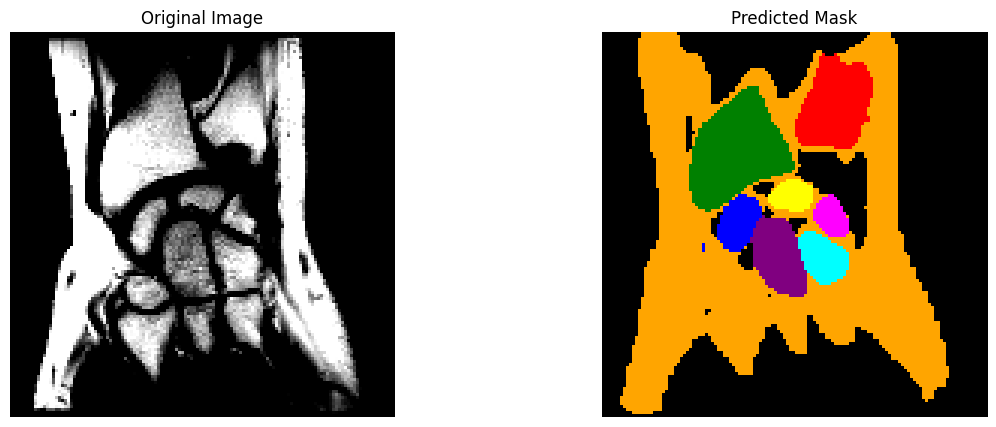

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


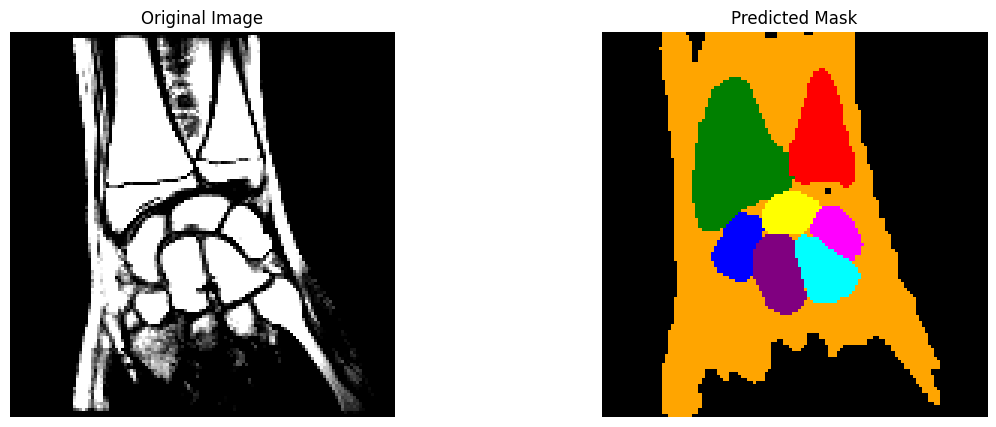

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


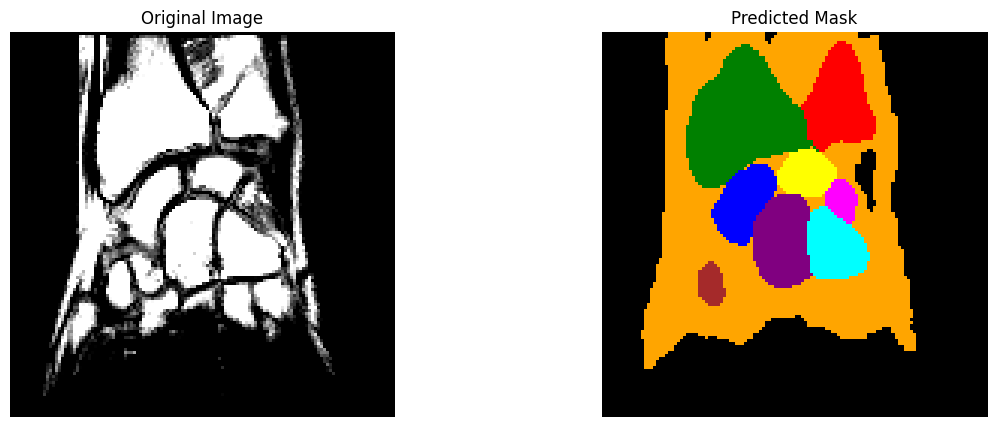

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


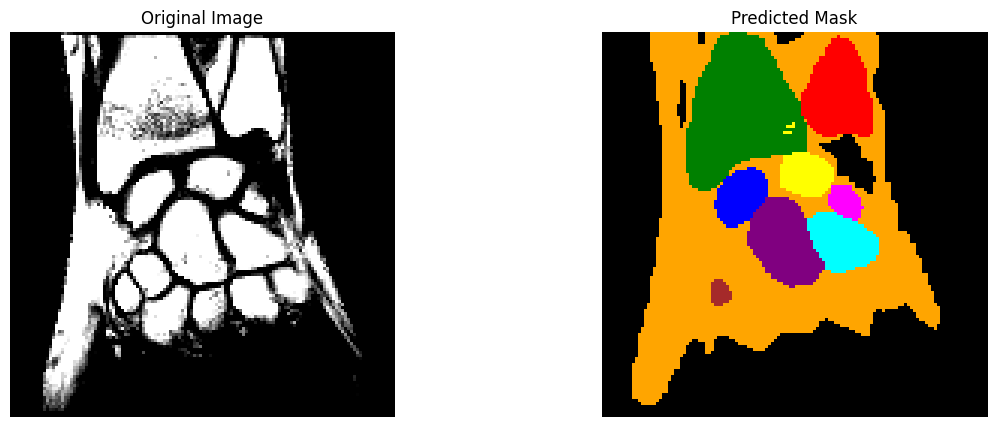

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


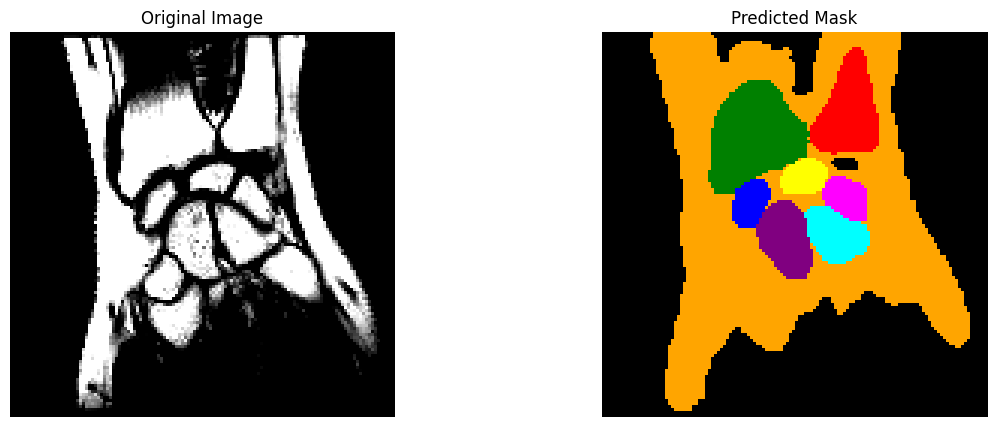

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


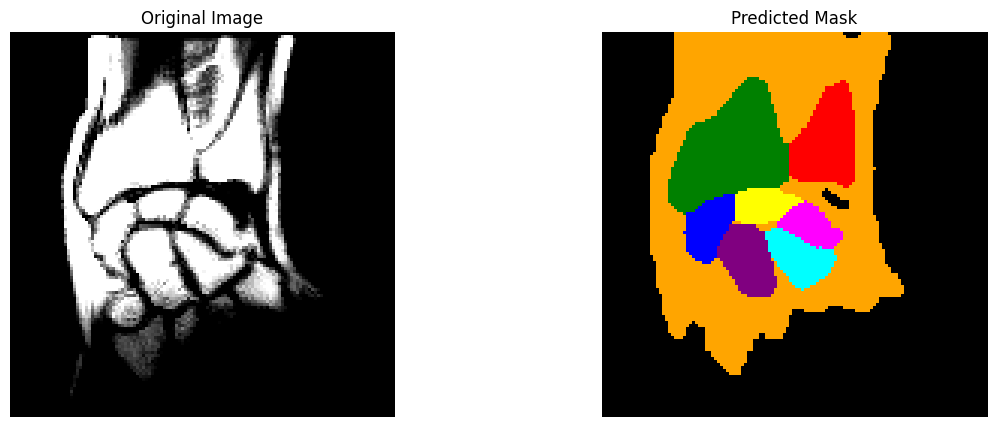

In [54]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from monai.transforms import Compose, LoadImaged, AddChanneld, NormalizeIntensityd, ScaleIntensityRanged, EnsureTyped, ToTensord, Activations, AsDiscrete
from monai.data import Dataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from glob import glob
from monai.networks.nets import UNETR
from matplotlib import colors

# Define paths
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks'  # Directory to save the predicted masks
os.makedirs(output_dir, exist_ok=True)

test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNETR(
    img_size=(128, 128, 64),  # Adjusted size to be divisible by 32 in all dimensions
    in_channels=1,
    out_channels=11,  # 10 bones + background
    feature_size=48,  # Reduced feature size
    depths=(2, 2,2,2),  # Example values, adjust as needed
    num_heads=(3, 6,12,24),  # Reduced number of heads
    norm_name="instance",
    use_checkpoint=True,
).to(device)


model.load_state_dict(torch.load("best_model_swinunetr.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Visualization function with custom colormap
def visualize_results(image, prediction, slice_num, num_classes=11):
    # Create a colormap with a unique color for each class
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, num_classes, num_classes + 1)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image[0, 0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction[0, :, :, slice_num], cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Run inference, save predicted masks, and visualize results
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        test_outputs = sliding_window_inference(test_images, (128, 128, 64), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Convert predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Save the predicted mask
    predicted_mask = test_outputs[0]  # Ensure correct shape selection
    original_image = nib.load(test_files[i]["image"])
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, f"predicted_mask_{i}.nii.gz"))

    # Visualize the results
    slice_num = 21# Change this value to visualize different slices
    visualize_results(test_images.cpu().numpy(), predicted_mask, slice_num)

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


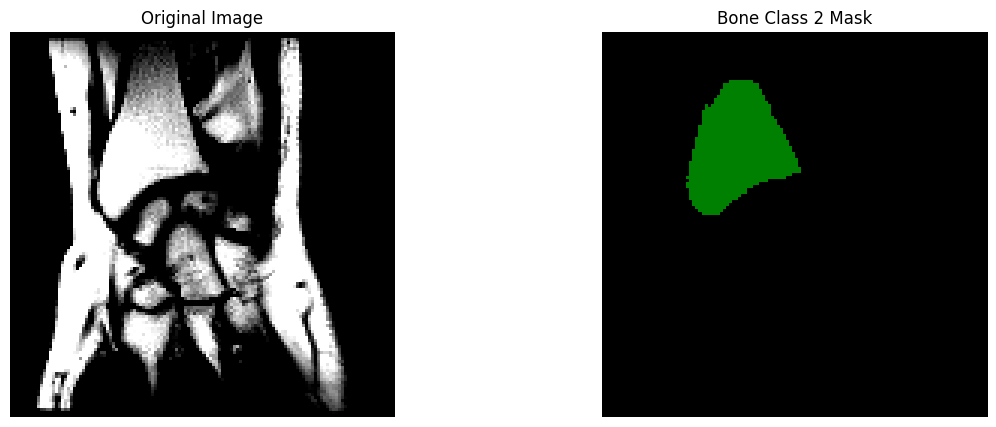

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


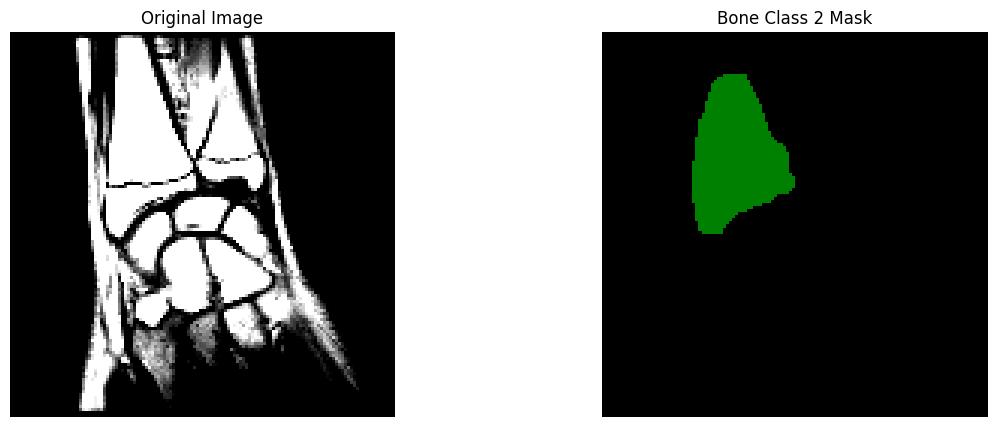

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


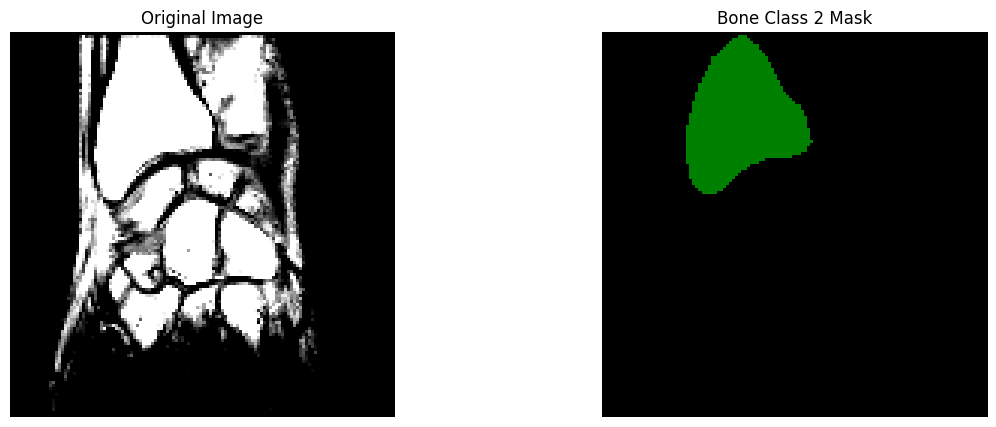

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


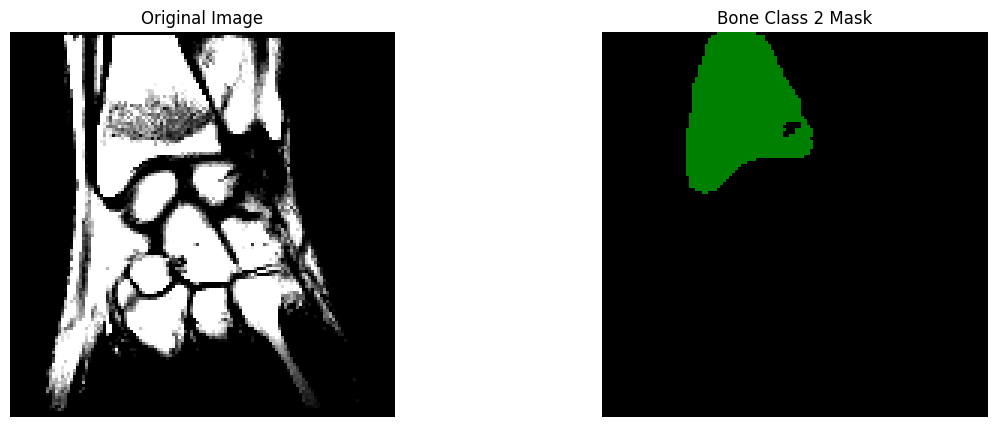

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


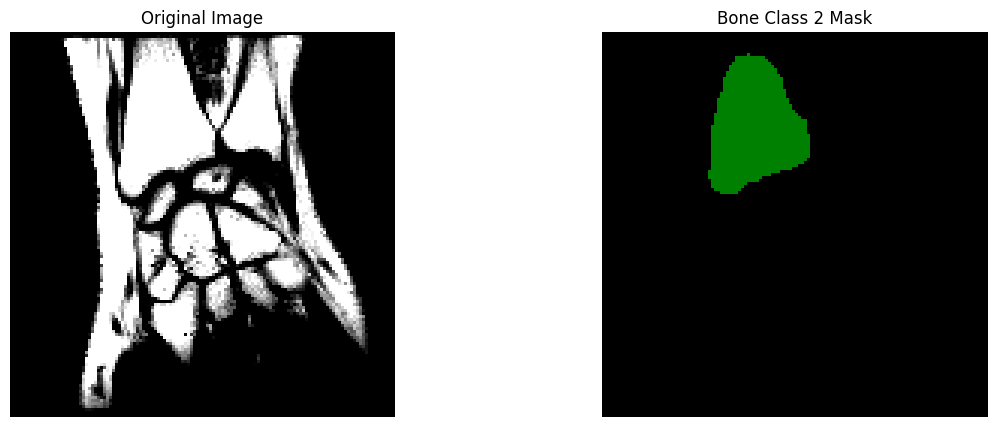

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


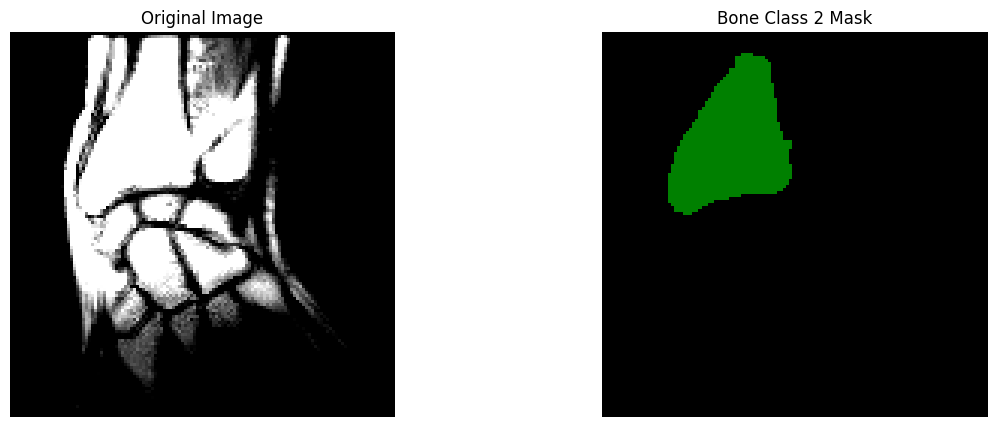

In [64]:
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks'  
os.makedirs(output_dir, exist_ok=True)


test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))


test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained SegResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNETR(
    img_size=(128, 128, 64),  # Adjusted size to be divisible by 32 in all dimensions
    in_channels=1,
    out_channels=11,  # 10 bones + background
    feature_size=48,  # Reduced feature size
    depths=(2, 2,2,2),  # Example values, adjust as needed
    num_heads=(3, 6,12,24),  # Reduced number of heads
    norm_name="instance",
    use_checkpoint=True,
).to(device)
model.load_state_dict(torch.load("best_model_swinunetr.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Visualization function for a specific bone class
def visualize_single_bone(image, prediction, bone_class, slice_num):
    # Create a colormap with a unique color for each class
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, 11, 12)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Isolating the bone class from prediction
    bone_mask = (prediction == bone_class).astype(np.uint8) * bone_class  # Ensure correct class value

    plt.figure(figsize=(14, 5))

    # Displaying the original image slice
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image[0, 0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    # Displaying the predicted bone mask slice
    plt.subplot(1, 2, 2)
    plt.title(f"Bone Class {bone_class} Mask")
    plt.imshow(bone_mask[0, :, :, slice_num], cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Running inference, save predicted masks, and visualize results
bone_class_to_visualize = 2
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        # Get predictions from the model
        test_outputs = sliding_window_inference(test_images, (128, 128, 64), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Saving the predicted mask
    predicted_mask = test_outputs[0]  
    original_image = nib.load(test_files[i]["image"])
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, f"predicted_mask_{i}.nii.gz"))

    # Visualizing the results for the selected bone class
    slice_num = 18
    visualize_single_bone(test_images.cpu().numpy(), predicted_mask, bone_class_to_visualize, slice_num)

In [65]:
# Directories
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks_swinunetr'  # Output directory for predicted masks
os.makedirs(output_dir, exist_ok=True)

# File paths
test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained SegResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNETR(
    img_size=(128, 128, 64),  # Adjusted size to be divisible by 32 in all dimensions
    in_channels=1,
    out_channels=11,  # 10 bones + background
    feature_size=48,  # Reduced feature size
    depths=(2, 2,2,2),  # Example values, adjust as needed
    num_heads=(3, 6,12,24),  # Reduced number of heads
    norm_name="instance",
    use_checkpoint=True,
).to(device)
model.load_state_dict(torch.load("best_model_swinunetr.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Function to save the predicted mask as a .nii.gz file
def save_predicted_mask_as_nii(prediction, affine, header, output_path):
    predicted_nifti = nib.Nifti1Image(prediction, affine, header)
    nib.save(predicted_nifti, output_path)

# Running inference and saving predicted masks
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    original_image_path = test_files[i]["image"]
    with torch.no_grad():
        # Get predictions from the model
        test_outputs = sliding_window_inference(test_images, (128, 128, 64), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Saving the predicted mask as a .nii.gz file
    predicted_mask = test_outputs[0, 0, :, :, :]  # Extract the full 3D mask
    original_image = nib.load(original_image_path)  # Load the original image for affine and header
    output_filename = os.path.basename(original_image_path)  # Get the original filename
    output_path = os.path.join(output_dir, output_filename)  # Construct the output path
    save_predicted_mask_as_nii(predicted_mask, original_image.affine, original_image.header, output_path)